<a href="https://colab.research.google.com/github/Sar314/1D_heat_eqn/blob/main/heat_equn_BD_chi(x).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1D Heat equation solved implicity using a backward difference approximation in time.

This version has a Neuman boundary condition at x=0, and  Dirchelet boundary condition at x=L.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import diags

In [2]:
# variables
L = np.pi   # rod length (3 in this case so that the final plot is symmetric and shows the oscillations from the initial conditions)
T = .3      # total time (s)
k = .5      # thermal diffusivity constant  
N = 30      # number of spatial steps
M = 30      # number of time steps
dx = L/N    # space steps
dt = T/M    # time steps
alpha = k*dt/dx**2
t_bound1 = 0.5 # constant value of U(L,t) for Dirchelet condition
t_bound2 = 1   # constant value of the dU(0,t)/dx for Neuman Condition

x = np.linspace(0,L,N)
t = np.linspace(0,T,M)

In [3]:
# Initial condition
u_0 = np.zeros((N,1), dtype=float)

for i in range(N):
  u_0[i] = np.sin(np.pi*x[i])

# Boundary Conditions just for initial u, the rest are included in the matrix equation below
u_0[-1] = t_bound1   # Dirchelet
u_0[0] = u_0[1]      # Neuman


In [4]:
############################# Source ###############################
def S(x):                                 # Gaussian Source 
  sigma = 0.3                             # FWHM
  return np.exp(-(x-1.5)**2/(2*sigma))    # centered at 1.5

def H(x):                                 # Step function source
  h = np.heaviside(x-2,0.5)               # step up at x=2
  return h

# source vector
s = np.zeros((N,1), dtype=object)
for i in range(N):
  s[i] = H(x[i])
####################################################################

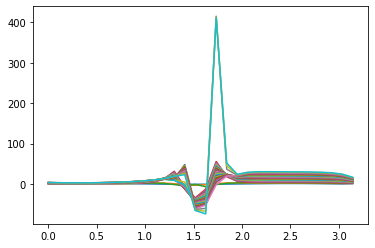

In [5]:
# Heat equation in terms of approximations with boundary conditions
# reseting u_0 for each run
for i in range(N):
  u_0[i] = np.sin(np.pi*x[i])

# Boundary Conditions just for initial u, the rest are included in the matrix equation below
u_0[-1] = t_bound1   # Dirchelet
u_0[0] = u_0[1]     # Neuman

u_0 = u_0.astype(float)
u_1 = np.zeros((N, 1), dtype=object)
u_out = [u_0]

for j in range(M):  # M steps in time
  
  # Creating the inverted matrix A including Dirchelet and Neuman boundary conditions

  def tridiag(a, b, c, k1=-1, k2=0, k3=1):
      return np.diag(a, k1) + np.diag(b, k2) + np.diag(c, k3)

  a = np.zeros(N-1)
  b = np.zeros(N) 
  c = np.zeros(N-1)
  chi = np.zeros(N, dtype=object)
  alpha = np.zeros(N,dtype=object)


  # for chi=1/r where can't have 1/0
  #chi[0] = 1
  #for i in range(1,N,1):
    #chi[i] = 1/x[i]

  for i in range(N):
    # options for chi: U, sqrt(U), 1/U, 1/r, r
    # comment following line when using chi=1/r
    chi[i] = 1/u_0[i]
    alpha[i] = chi[i]*dt/dx**2 
    b[i] = 1 + 2*alpha[i]
  for i in range(N-1):
    a[i] = -alpha[i+1]
  for i in range(N-1):
    c[i] = -alpha[i]

  A = tridiag(a, b, c)
  A[0, 1] = -2*alpha[1]
  Inv_A = np.linalg.inv(A)

  # Creating the b vector which results from the boundary conditions

  b = np.zeros((N, 1), dtype=object)
  b[0], b[-1] = 2*t_bound2*alpha[0]*dx, alpha[-1]*t_bound1
  
  u_1 = np.matmul(Inv_A, (u_0 + b + s))
  u_out.append(u_1)
  plt.plot(x, u_out[j])
  plt.grid()
  u_0 = u_1